### Coupled Simple Land Simulations

##### Marysa M Laguë
##### 2017.02.22

## Comparison of coupled simulations using maps and vertical cross sections to look at how various pertubations of albedo, height, evaporative resistance, and soil heat capacity change selected variables.

## Setup 
(This section just has code needed to manipulate the netcdf files, make plots, load data, etc)

### modules


In [26]:
# For interactive in-line plots:
#%matplotlib nbagg  

# For inline plots:
%matplotlib inline     

import matplotlib as mpl
import numpy as np
import os
import datetime
import netCDF4 as nc
import xarray as xr
from scipy import interpolate
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import brewer2mpl as cbrew
import scipy.io as sio

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

In [27]:
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

### Functions

##### Plotting

### Maps:

In [28]:

def mml_fig(LN,LT,mapdata,ds,myvar,proj,title=None,clim=None,colmap=None,units=None):
    #x_data, y_data, x_label, y_label, title=None, xlim=None, ylim=None
    ''' Desctiption of function goes here. Also, single and double quotes are the same...'''

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    mp = Basemap(projection='robin',lon_0=180.,lat_0 = 0) # can't make it start anywhere other than 180???
    mp.drawcoastlines()
    mp.drawmapboundary(fill_color='1.')  # make map background white
    parallels = np.arange(-90.,90,20.)
    mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
    meridians = np.arange(0.,360.,20.)
    mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])
    #(x, y) = m(LONXY, LATXY)
    cs = mp.pcolormesh(LN,LT,mapdata,cmap=plt.cm.inferno,latlon=True)
    
    if cm:
        cs.cmap = colmap
    else:
        cs.cmap = plt.cm.inferno    
    
    cbar = mp.colorbar(cs,location='bottom',pad="5%")
    cbar.set_label('units: '+ds[myvar].units)
    
    if title:
        plt.title(title,fontsize=12)
    else:
        plt.title(ds[myvar].long_name,fontsize=12)
    
    if clim:
        cbar.set_clim(clim[0],clim[1])
        cs.set_clim(clim[0],clim[1])
    
    
    
    
    #plt.suptitle('units?')
    #plt.show()
    
    
    #plt.show()
    return fig, mp, ax, cbar, cs

def mml_map(LN,LT,mapdata,ds,myvar,proj,title=None,clim=None,colmap=None,cb_ttl=None):
    # need to have already opened a figure/axis
    #plt.sca(ax)
    
    # There is a way to make a single basemap, save it, and just call that vover and over, ie a blank little map, 
    # that we then build maps on top of (pcolours)
    mp = Basemap(projection='robin',lon_0=180.,lat_0 = 0,resolution='c') # can't make it start anywhere other than 180???
    mp.drawcoastlines()
    mp.drawmapboundary(fill_color='1.')  # make map background white
    parallels = np.arange(-90.,90,20.)
    mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
    meridians = np.arange(0.,360.,20.)
    mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])
    #(x, y) = m(LONXY, LATXY)
    cs = mp.pcolormesh(LN,LT,mapdata,cmap=plt.cm.inferno,latlon=True)
    
    if cm:
        cs.cmap = colmap
    else:
        cs.cmap = plt.cm.inferno    
    
    cbar = mp.colorbar(cs,location='bottom',pad="5%")
    
    if cb_ttl:
        cbar.set_label(cb_ttl,fontsize=12)
    else:
        cbar.set_label('units: '+ds[myvar].units,fontsize=12)
    
    if title:
        plt.title(title,fontsize=12)
    else:
        plt.title(ds[myvar].long_name,fontsize=12)
    
    if clim:
        cbar.set_clim(clim[0],clim[1])
        cs.set_clim(clim[0],clim[1])
    
    
    
    
    #plt.suptitle('units?')
    #plt.show()
    
    
    #plt.show()
    return mp, cbar, cs



### Single perturbation grid comparisions

In [29]:

def sl_clm_fig(myvar,myds,mapdata_1,mapdata_2,mapdata_3,ttl_1,ttl_2,ttl_3,ttl_main,clim_abs,clim_diff,units,cmap_abs,cmap_diff):

    ###  Make a 3x3 subplot
    fig, axes = plt.subplots(3, 3, figsize=(20,12))

    # hide the plots below the diagonal
    axes[1, 0].axis('off')
    axes[2, 0].axis('off')
    axes[2, 1].axis('off')

    # CLM 4.5:
    ax0 = axes.flatten()[0]
    plt.sca(ax0)
    mapdata_nan = mapdata_1
    #create masked array where nan=mask. pcolormesh does not like NaNs.
    mapdata1 = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
    ttl = ttl_1

    mp0, cbar0, cs0 = mml_map(LN,LT,mapdata1,myds,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    #cbar0.title('units = unitless')

    # SL_clm: 
    ax1 = axes.flatten()[1]
    plt.sca(ax1)
    mapdata_nan = mapdata_2
    #create masked array where nan=mask. pcolormesh does not like NaNs.
    mapdata2 = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
    ttl = ttl_2

    mp2, cbar2, cs2 = mml_map(LN,LT,mapdata2,myds,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r


    # SL_ceres:
    ax2 = axes.flatten()[2]
    plt.sca(ax2)
    mapdata_nan = mapdata_3
    #create masked array where nan=mask. pcolormesh does not like NaNs.
    mapdata3 = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
    ttl = ttl_3
    mp3, cbar3, cs3 = mml_map(LN,LT,mapdata3,myds,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )


    # SL_clm - clm5:
    ax4 = axes.flatten()[4]
    plt.sca(ax4)
    mapdata_nan = mapdata_sl - mapdata_clm
    #create masked array where nan=mask. pcolormesh does not like NaNs.
    mapdata12 = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
    ttl = 'Simple Land (clm '+r'$\alpha$'+') - CLM5.0'
    mp3, cbar3, cs3 = mml_map(LN,LT,mapdata12,myds,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )

    # SL_cer - clm5:
    ax5 = axes.flatten()[5]
    plt.sca(ax5)
    mapdata_nan = mapdata_3 - mapdata_1
    #create masked array where nan=mask. pcolormesh does not like NaNs.
    mapdata13 = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
    ttl = 'Simple Land (ceres '+r'$\alpha$'+') - CLM5.0'
    mp3, cbar3, cs3 = mml_map(LN,LT,mapdata13,myds,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )


    # SL_cer - SL_clm:
    ax8 = axes.flatten()[8]
    plt.sca(ax8)
    mapdata_nan = mapdata_3 - mapdata_2
    #create masked array where nan=mask. pcolormesh does not like NaNs.
    mapdata23 = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
    ttl = 'Simple Land ceres '+r'$\alpha$'+' - clm '+r'$\alpha$'
    mp3, cbar3, cs3 = mml_map(LN,LT,mapdata23,myds,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )



    # Figure title
    fig.subplots_adjust(top=0.95)
    fig.suptitle(ttl_main, 
                 fontsize=18)

    return fig,axes

def pert_hi_lo_fig(myvar,ds1,ds2,ds3,mapdata_1,mapdata_2,mapdata_3,ttl_1,ttl_2,ttl_3,ttl_main,clim_abs,clim_diff,units,cmap_abs,cmap_diff,LN,LT):
    # Make a 3x3 plot showing how high and low perturbations effect some field
    
    # Inputs:
    # myvar: string corresponding to the variable in question
    # ds1, ds2, ds3 : the handles for the 3 data sets of interest
    # mapdata_1, mapdata_2, mapdata_3 : the mapdata for each simulation - not using ds directly incase its a field we have to calculate
    # ttl_1, ttl_2, ttl_3 : names of each simulation, e.g. "simulation 1" 
    # ttl_main : the title explaining what we're plotting
    
    
    fig, axes = plt.subplots(3, 3, figsize=(20,18))
    
    # ds1:
    ax0 = axes.flatten()[0]
    plt.sca(ax0)
    ttl = ttl_1

    mp0, cbar0, cs0 = mml_map(LN,LT,mapdata_1,ds1,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r

    # blank: 
    #ax1 = axes.flatten()[1]
    #plt.sca(ax1)
    axes[0, 1].axis('off')

    # blank:
    #ax2 = axes.flatten()[2]
    #plt.sca(ax2)
    axes[0, 2].axis('off')
    
    # ds2:
    ax3 = axes.flatten()[3]
    plt.sca(ax3)
    ttl = ttl_2

    mp0, cbar0, cs0 = mml_map(LN,LT,mapdata_2,ds1,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r

    # ds1 - ds2:
    ax4 = axes.flatten()[4]
    plt.sca(ax4)
    ttl = ttl_1 + ' - ' + ttl_2
    mapdata = mapdata_1 - mapdata_2

    mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds1,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r

    # blank
    #ax5 = axes.flatten()[5]
    #plt.sca(ax5)
    axes[1, 2].axis('off')
    
    # ds3:
    ax6 = axes.flatten()[6]
    plt.sca(ax6)
    ttl = ttl_3

    mp0, cbar0, cs0 = mml_map(LN,LT,mapdata_3,ds1,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r

    # ds1 - ds3:
    ax7 = axes.flatten()[7]
    plt.sca(ax7)
    ttl = ttl_1 + ' - ' + ttl_3
    mapdata = mapdata_1 - mapdata_3

    mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds1,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    
    # ds2 - ds3:
    ax8 = axes.flatten()[8]
    plt.sca(ax8)
    ttl = ttl_2 + ' - ' + ttl_3
    mapdata = mapdata_2 - mapdata_3

    mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds1,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r


    fig.subplots_adjust(top=0.95)
    fig.suptitle(ttl_main, 
                 fontsize=18)

    return fig,axes


### Grids of maps

In [30]:

def pert4_map_fig(myvar,ds0,ds1a,ds1b,ds2a,ds2b,ds3a,ds3b,ds4a,ds4b, \
              mapdata_0,mapdata_1a,mapdata_1b,mapdata_2a,mapdata_2b,mapdata_3a,mapdata_3b,mapdata_4a,mapdata_4b, \
              ttl_0,ttl_1a,ttl_1b,ttl_2a,ttl_2b,ttl_3a,ttl_3b,ttl_4a,ttl_4b, \
              ttl_main,clim_abs,clim_diff,units,cmap_abs,cmap_diff,LN,LT):
    # Make a 3x4 plot showing the response of a single variable across the 4 different perturbation experiments, plotting
    #
    # alpha1 - base    |    alpha2 - base   |     alpha1 - alpha2
    # h1 - base        |    h2 - base       |     h1 - h2
    # cv1 - base       |    cv2 - base      |     cv1 - cv2
    # rs1 - base       |    rs2 - base      |     rs1 - rs2
    #
    #
    
    # Inputs:
    # myvar: string corresponding to the variable in question
    # ds0, mapdata_0, ttl_0 = info for the base case (no perturbations)
    # ds1a, ds1b, etc : the handles for the 4 data sets of interest, where a is the lower perturbation and b is the higher perturbation
    # mapdata_1, mapdata_2, mapdata_3 : the mapdata for each simulation - not using ds directly incase its a field we have to calculate
    # ttl_1, ttl_2, ttl_3 : names of each simulation, e.g. "simulation 1" 
    # ttl_main : the title explaining what we're plotting
    
    
    fig, axes = plt.subplots(4, 3, figsize=(40,30))
    
    #------------------------------------------
    # ALBEDO 
    
    # alpha1 - base :
    ax0 = axes.flatten()[0]
    plt.sca(ax0)
    ttl = 'Low albedo (alpha=.1) - base (alpha=.2)'
    mapdata = mapdata_1a - mapdata_0

    mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    
    ax=ax0
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    
    # alpha2 - base :
    ax1 = axes.flatten()[1]
    plt.sca(ax1)
    ttl = 'High albedo (alpha=.3) - base (alpha=.2)'
    mapdata = mapdata_1b - mapdata_0

    mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    
    
    # alpha1 - alpha2 :
    ax2 = axes.flatten()[2]
    plt.sca(ax2)
    ttl = 'Low albedo (alpha=.1) - high albedo (alpha=.3)'
    mapdata = mapdata_1a - mapdata_1b

    mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r

    #------------------------------------------
    # ROUGHNESS HEIGHT
    
    # hc1 - base :
    ax3 = axes.flatten()[3]
    plt.sca(ax3)
    ttl = 'Low roughness (h=.5 m) - base (h=1 m)'
    mapdata = mapdata_2a - mapdata_0

    mp3, cbar3, cs3 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r

    # hc2 - base :
    ax4 = axes.flatten()[4]
    plt.sca(ax4)
    ttl = 'High roughness (h=10 m) - base (h=1 m)'
    mapdata = mapdata_2b - mapdata_0

    mp4, cbar4, c4 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r


    # hc1 - hc2 :
    ax5 = axes.flatten()[5]
    plt.sca(ax5)
    ttl = 'Low roughness (h=.5 m) - high roughness (h=10 m)'
    mapdata = mapdata_2a - mapdata_2b

    mp5, cbar5, cs5 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r

    #------------------------------------------
    # Evaporative Resistance
    
    # rs1 - base :
    ax6 = axes.flatten()[6]
    plt.sca(ax6)
    ttl = 'Low evap resistance (res=30 s/m) - base (res=100 s/m))'
    mapdata = mapdata_3a - mapdata_0

    mp6, cbar6, cs6 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r

    # rs2 - base :
    ax7 = axes.flatten()[7]
    plt.sca(ax7)
    ttl = 'High evap resistance (res=200 s/m)) - base (res=100 s/m))'
    mapdata = mapdata_3b - mapdata_0

    mp7, cbar7, cs7 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r


    # rs1 - s2
    ax8 = axes.flatten()[8]
    plt.sca(ax8)
    ttl = 'Low evap res (res=30 s/m)) - high evap res (res=200 s/m))'
    mapdata = mapdata_3a - mapdata_3b

    mp8, cbar8, cs8 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r

    #------------------------------------------
    # SOIL HEAT CAPACITY
    
    # cv1 - base :
    ax9 = axes.flatten()[9]
    plt.sca(ax9)
    ttl = 'Low soil heat capacity (cv=1.5e6 J/m3/K) - base (cv=2e6 J/m3/K)'
    mapdata = mapdata_4a - mapdata_0

    mp9, cbar9, cs9 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r

    # cv2 - base :
    ax10 = axes.flatten()[10]
    plt.sca(ax10)
    ttl = 'High soil heat capacity (cv=3e6 J/m3/K) - base (cv=2e6 J/m3/K)'
    mapdata = mapdata_4b - mapdata_0

    mp10, cbar10, cs10 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r


    # cv2 - cv2 :
    ax11 = axes.flatten()[11]
    plt.sca(ax11)
    ttl = 'Low (cv=1.5e6 J/m3/K) - high (cv=3e6 J/m3/K) soil heat capacity'
    mapdata = mapdata_4a - mapdata_4b

    mp11, cbar11, cs11= mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r

    #------------------------------------------
    
    axs=[ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]
    for ax in axs:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(24)
    
    cbs=[cbar0,cbar1,cbar2,cbar3,cbar4,cbar5,cbar6,cbar7,cbar8,cbar9,cbar10,cbar11]
    for cb in cbs:
        ax = cb.ax
        cb.ax.tick_params(labelsize=14)
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(20)
        #for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        #    item.set_fontsize(20)
    
    fig.subplots_adjust(top=0.95)
    fig.suptitle(ttl_main, 
                 fontsize=30)

    return fig,axes


### Zonal Figures

In [31]:


def zonal_fig(data,lat,lev,colmap,clim,ttl,units,levels):
    
    mp = plt.contourf(np.sin(lat*np.pi/180),lev,data,levels,cmap=colmap)
    
    mp.set_clim(vmin=clim[0],vmax=clim[1])

    #mp.colorbar()
    #cbar = plt.colorbar(mp,boundaries=np.linspace(clim[0], clim[1], 50))
    #cbar = plt.colorbar(mp,vmin=clim[0],vmax=clim[1])
    cbar = plt.colorbar(mp)
    #cbar = 
    cbar.set_label(units,fontsize=20)
    #cbar.set_clim(vmin=clim[0],vmax=clim[1])
    #cbar.ax.set_clim(vmin=clim[0],vmax=clim[1])
    
    
    plt.title(ttl)
    plt.ylabel('Pressure [hPa]')
    plt.xlabel('Latitude [degrees N]')

    tx = np.sin(np.array([-90,-60,-30,0,30,60,90])*np.pi/180)
    tx_name = ['-90','-60','-30','0','30','60','90']
    ax0.set_xticks(tx)
    ax0.set_xticklabels(tx_name)
 
    return mp, cbar


def pert4_zonal_fig(myvar,ds0,ds1a,ds1b,ds2a,ds2b,ds3a,ds3b,ds4a,ds4b, \
              mapdata_0,mapdata_1a,mapdata_1b,mapdata_2a,mapdata_2b,mapdata_3a,mapdata_3b,mapdata_4a,mapdata_4b, \
              ttl_0,ttl_1a,ttl_1b,ttl_2a,ttl_2b,ttl_3a,ttl_3b,ttl_4a,ttl_4b, \
              ttl_main,clim_abs,clim_diff,units,cmap_abs,cmap_diff,LN,LT):
    # Make a 3x4 plot showing the response of a single variable AS A VERTICAL X ZONAL plot
    # across the 4 different perturbation experiments, plotting
    #
    # alpha1 - base    |    alpha2 - base   |     alpha1 - alpha2
    # h1 - base        |    h2 - base       |     h1 - h2
    # cv1 - base       |    cv2 - base      |     cv1 - cv2
    # rs1 - base       |    rs2 - base      |     rs1 - rs2
    #
    # with sin(lat) on the x-axis and pressure on the y axis
    #
    # Input (mapdata) should be provided already in a zonal format, ie lat x vert , so that there is flexibility
    # as far as plotting averages vs sums goes. 
    
    # Inputs:
    # myvar: string corresponding to the variable in question
    # ds0, mapdata_0, ttl_0 = info for the base case (no perturbations)
    # ds1a, ds1b, etc : the handles for the 4 data sets of interest, where a is the lower perturbation and b is the higher perturbation
    # mapdata_1, mapdata_2, mapdata_3 : the mapdata for each simulation - not using ds directly incase its a field we have to calculate
    # ttl_1, ttl_2, ttl_3 : names of each simulation, e.g. "simulation 1" 
    # ttl_main : the title explaining what we're plotting

    
    fig, axes = plt.subplots(4, 3, figsize=(40,30))
    
    lat = ds0.lat.values
    lev = ds0.lev.values
    
    clim = clim_diff
    levels = np.linspace(clim[0], clim[1], 50)
    
    #------------------------------------------
    # ALBEDO 
    
    # alpha1 - base :
    ax0 = axes.flatten()[0]
    plt.sca(ax0)
    ttl = 'Low albedo (alpha=.1) - base (alpha=.2)'
    data = mapdata_1a - mapdata_0
    
    #p0 = plt.contourf(mapdata,cmap=cmap_diff)
    #ax0.set_ylim(0)
    #mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    mp0, cb0 = zonal_fig(data,lat,lev,colmap=cmap_diff,clim=clim_diff,ttl=ttl,units=units,levels=levels)

    
    # alpha2 - base :
    ax1 = axes.flatten()[1]
    plt.sca(ax1)
    ttl = 'High albedo (alpha=.3) - base (alpha=.2)'
    data = mapdata_1b - mapdata_0

    #mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    mp1, cb1 = zonal_fig(data,lat,lev,colmap=cmap_diff,clim=clim_diff,ttl=ttl,units=units,levels=levels)

    
    # alpha1 - alpha2 :
    ax2 = axes.flatten()[2]
    plt.sca(ax2)
    ttl = 'Low albedo (alpha=.1) - high albedo (alpha=.3)'
    data = mapdata_1a - mapdata_1b

    #mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    mp2, cb2 = zonal_fig(data,lat,lev,colmap=cmap_diff,clim=clim_diff,ttl=ttl,units=units,levels=levels)

    #------------------------------------------
    # ROUGHNESS HEIGHT
    
    # hc1 - base :
    ax3 = axes.flatten()[3]
    plt.sca(ax3)
    ttl = 'Low roughness (h=.5 m) - base (h=1 m)'
    data = mapdata_2a - mapdata_0

    #mp3, cbar3, cs3 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    mp3, cb3 = zonal_fig(data,lat,lev,colmap=cmap_diff,clim=clim_diff,ttl=ttl,units=units,levels=levels)

    # hc2 - base :
    ax4 = axes.flatten()[4]
    plt.sca(ax4)
    ttl = 'Low roughness (h=10 m) - base (h=1 m)'
    data = mapdata_2b - mapdata_0

    #mp4, cbar4, c4 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    mp4, cb4 = zonal_fig(data,lat,lev,colmap=cmap_diff,clim=clim_diff,ttl=ttl,units=units,levels=levels)


    # hc1 - hc2 :
    ax5 = axes.flatten()[5]
    plt.sca(ax5)
    ttl = 'Low roughness (h=.5 m) - high roughness (h=10 m)'
    data = mapdata_2a - mapdata_2b

    #mp5, cbar5, cs5 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    mp5, cb5 = zonal_fig(data,lat,lev,colmap=cmap_diff,clim=clim_diff,ttl=ttl,units=units,levels=levels)

    #------------------------------------------
    # Evaporative Resistance
    
    # rs1 - base :
    ax6 = axes.flatten()[6]
    plt.sca(ax6)
    ttl = 'Low evap resistance (res=30 s/m) - base (res=100 s/m))'
    data = mapdata_3a - mapdata_0

    #mp6, cbar6, cs6 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    mp6, cb6 = zonal_fig(data,lat,lev,colmap=cmap_diff,clim=clim_diff,ttl=ttl,units=units,levels=levels)

    # rs2 - base :
    ax7 = axes.flatten()[7]
    plt.sca(ax7)
    ttl = 'High evap resistance (res=200 s/m)) - base (res=100 s/m))'
    data = mapdata_3b - mapdata_0

    #mp7, cbar7, cs7 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    mp7, cb7 = zonal_fig(data,lat,lev,colmap=cmap_diff,clim=clim_diff,ttl=ttl,units=units,levels=levels)


    # rs1 - s2
    ax8 = axes.flatten()[8]
    plt.sca(ax8)
    ttl = 'Low evap res (res=30 s/m)) - high evap res (res=200 s/m))'
    data = mapdata_3a - mapdata_3b

    #mp8, cbar8, cs8 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    mp8, cb8 = zonal_fig(data,lat,lev,colmap=cmap_diff,clim=clim_diff,ttl=ttl,units=units,levels=levels)

    #------------------------------------------
    # SOIL HEAT CAPACITY
    
    # cv1 - base :
    ax9 = axes.flatten()[9]
    plt.sca(ax9)
    ttl = 'Low soil heat capacity (cv=1.5e6 J/m3/K) - base (cv=2e6 J/m3/K)'
    data = mapdata_4a - mapdata_0

    #mp9, cbar9, cs9 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    mp9, cb9 = zonal_fig(data,lat,lev,colmap=cmap_diff,clim=clim_diff,ttl=ttl,units=units,levels=levels)

    # cv2 - base :
    ax10 = axes.flatten()[10]
    plt.sca(ax10)
    ttl = 'High soil heat capacity (cv=3e6 J/m3/K) - base (cv=2e6 J/m3/K)'
    data = mapdata_4b - mapdata_0

    #mp10, cbar10, cs10 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    mp10, cb10 = zonal_fig(data,lat,lev,colmap=cmap_diff,clim=clim_diff,ttl=ttl,units=units,levels=levels)


    # cv2 - cv2 :
    ax11 = axes.flatten()[11]
    plt.sca(ax11)
    ttl = 'Low (cv=1.5e6 J/m3/K) - high (cv=3e6 J/m3/K) soil heat capacity'
    data = mapdata_4a - mapdata_4b

    #mp11, cbar11, cs11= mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
    mp11, cb11 = zonal_fig(data,lat,lev,colmap=cmap_diff,clim=clim_diff,ttl=ttl,units=units,levels=levels)

    
    #------------------------------------------
    
    axs=[ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]
    for ax in axs:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(24)
    
    cbs=[cb0,cb1,cb2,cb3,cb4,cb5,cb6,cb7,cb8,cb9,cb10,cb11]
    for cb in cbs:
        ax = cb.ax
        cb.ax.tick_params(labelsize=14)
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(20)
        #for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        #    item.set_fontsize(20)
    
    fig.subplots_adjust(top=0.95)
    fig.suptitle(ttl_main, 
                 fontsize=30)

    return fig,axes

***

## Load the data 
(Point to the location of the files then open with xarray)

In [32]:
# Path to save figures:
figpath = '/home/disk/eos3/mlague/simple_land/scripts/python/analysis/global_pert/figures/'

# Point at the data sets
ext_dir = '/home/disk/eos3/mlague/cesmruns/SimpleLand/global_pert/'

# Coupled simulations:
sims = ['global_a2_cv2_hc1_rs100',
       'global_a1_cv2_hc1_rs100','global_a3_cv2_hc1_rs100',
       'global_a2_cv1.5_hc1_rs100','global_a2_cv3_hc1_rs100',
       'global_a2_cv2_hc0.5_rs100','global_a2_cv2_hc10_rs100',
       'global_a2_cv2_hc1_rs30','global_a2_cv2_hc1_rs200']

# load the file paths and # Open the coupled data sets in xarray
cam_files = {}
clm_files = {}
ds_cam = {}
ds_clm = {}

for run in sims:
    #print ( ext_dir + run + '/means/' + run + '.cam.h0.05-end_year_avg.nc' )
    cam_files[run] = ext_dir + run + '/means/' + run + '.cam.h0.05-end_year_avg.nc'
    clm_files[run] = ext_dir + run + '/means/' + run + '.clm2.h0.05-end_year_avg.nc'
    
    ds_cam[run] = xr.open_dataset(cam_files[run])
    ds_clm[run] = xr.open_dataset(clm_files[run])


# open a cam area file produced in matlab using an EarthEllipsoid from a cam5 f19 lat/lon data set
area_f19_mat = sio.loadmat('/home/disk/eos3/mlague/simple_land/scripts/python/analysis//f19_area.mat')
area_f19 = area_f19_mat['AreaGrid']


/home/disk/p/mlague/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:389: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/home/disk/p/mlague/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:408: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


### Load some standard variables
lat, lon, landmask

In [33]:
ds = ds_clm['global_a2_cv2_hc1_rs100']
lat = ds['lat'].values
lon = ds['lon'].values
landmask = ds['landmask'].values

LN,LT = np.meshgrid(lon,lat)

#print(np.shape(LN))
#print(np.shape(landmask))


***
# Analysis

Here, I'll be focussing on the roughness simulations - specifically, the difference between hc0.5 and hc10 (the extremes). When I get the results from Eliza's runs, I should redo this analysis on hc0.5 vs hc2, which is a more "realistic" bound. 

Specifically, I'm trying to track down why the temperature response to a change in surface roughness is so much weaker over northern Eurasia than it is everywhere else.

### Possible ideas:
- Topography driven: It is occuring in a region likely largely influenced by the prescence of the Tibetan Plateau / general high mountains. There is also a *weaker* response downstream of the Rockies in North America than there is elsewhere in NA. The Andes and South Africa also have some big topography - focus on response there to see if there may be some relatioship? 
    - One possible way to pursue this would be to flatten topography and look at the response. The question there to me immediately becomes "how much to flatten, and where" - e.g. leave Antarctica alone? Its a pretty giant mountain at the pole, and I don't want to look at the influence of changing *that*. But then, what to do with Greenland? Its big, and Eurasia is downstream of that. Flattening it independently of flattening Tibet could be potentially useful, but is an extra simulation and I'm not sure we'd expect it to have that big an influence (the Jet upshoot over Western Europe is typically thought to be the result of the Rockies, correct? Not Greenland.)
    - On the bright side, we've got a fair bit of computation time left on the ITCZ grant that hasn't been used, so I could just tear through a bunch of simulations before that time expires in June.
- Seasonal/Dirunal response?
    - Gordon suggested that the turbulent heat fluxes could be opposite that expected during the cold season and/or at night; I only have monthly output, but I can certainly look at the seasonal variation here. 
    - If that looks promising, I could run a year with higher frequency output, in order to explore if the same response is occuring diurnally. 

In [52]:
# Define data sets and subtitles
ds0 = ds_cam['global_a2_cv2_hc0.5_rs100']

# perturbatinos
ds1 = ds_cam['global_a2_cv2_hc1_rs100']
ds2 = ds_cam['global_a2_cv2_hc10_rs100']

# land files
dsl0 = ds_clm['global_a2_cv2_hc0.5_rs100']
dsl1 = ds_clm['global_a2_cv2_hc1_rs100']
dsl2 = ds_clm['global_a2_cv2_hc10_rs100']

## Fetch some masks

(96, 144)


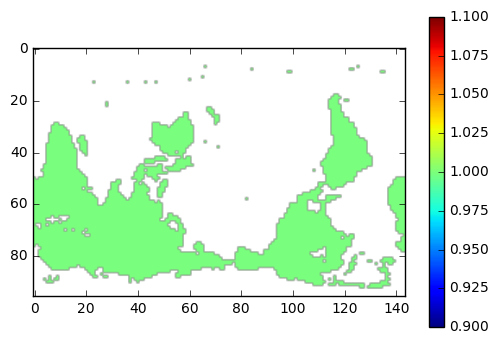

In [95]:
ds = ds_clm['global_a2_cv2_hc1_rs100']
lat = ds['lat'].values
lon = ds['lon'].values
landmask = ds['landmask'].values
landmask_nan = np.where(landmask==1,landmask,np.nan)
ocnmask_nan = landmask_nan.copy
ocnmask_nan = np.where(landmask==1,np.nan,1)

LN,LT = np.meshgrid(lon,lat)

# Get a glacier mask, too!
temp = np.mean(ds.mean('time')['MML_cv'].values[:],0)
print(np.shape(temp))
#plt.imshow(temp)
#plt.colorbar()
temp2 = temp.copy()
is_glc = np.where(temp2>1950000,np.nan,1)*landmask_nan
no_glc = np.where(temp2>1950000,1,np.nan)


ocn_glc_mask = ocnmask_nan.copy()
ocn_glc_mask = np.where(np.isnan(is_glc)==False,1,ocn_glc_mask)

bareground_mask = ocn_glc_mask.copy()
bareground_mask = np.where(np.isnan(ocn_glc_mask),1,np.nan)

plt.imshow(bareground_mask)
plt.colorbar()


## Annual Means
### T surface

In [35]:
# Plots
myvar = 'TS'

# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = '$\Delta$ Surface Temperature [K]'
filename = myvar+'_3maps'

clim_abs = [220,320]
clim_diff = [-2.5,2.5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

# hc0.5 - hc1
mapdata_nan = ds0[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#print(np.shape(mapdata))
mapdata_0 = np.mean(mapdata,0)
#print(np.shape(mapdata_0))

# hc10 - hc1
mapdata_nan = ds2[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_1 = np.mean(mapdata,0)

# hc0.5 - hc10
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_2 = np.mean(mapdata,0)





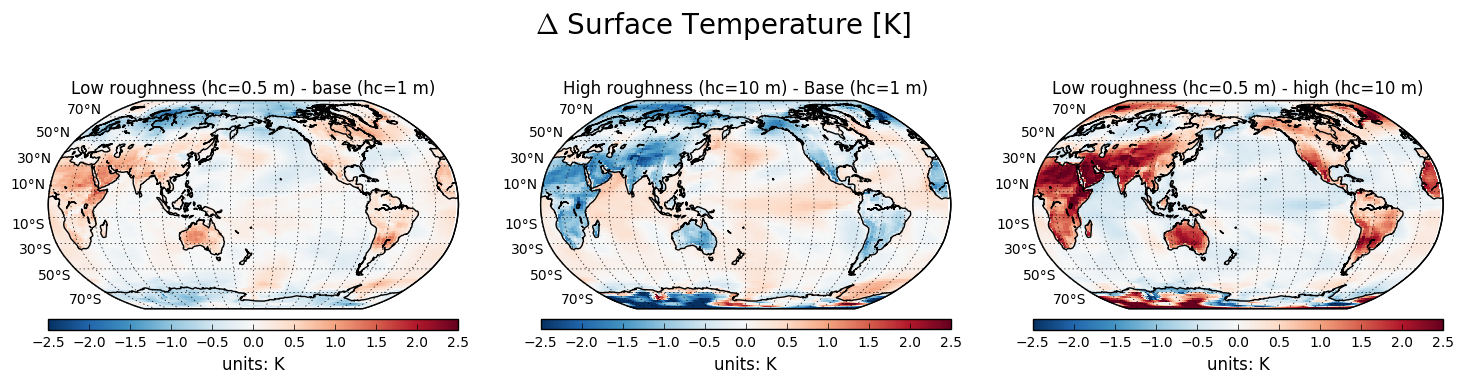

In [36]:

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'Low roughness (hc=0.5 m) - base (hc=1 m)'
mapdata = mapdata_0
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'High roughness (hc=10 m) - Base (hc=1 m)'
mapdata = mapdata_1
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'Low roughness (hc=0.5 m) - high (hc=10 m)'
mapdata = mapdata_2
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)

### T 2m reference height

In [37]:
# Plots
myvar = 'TREFHT'

# hc0.5 - hc1
mapdata_nan = ds0[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#print(np.shape(mapdata))
mapdata_0 = np.mean(mapdata,0)
#print(np.shape(mapdata_0))

# hc10 - hc1
mapdata_nan = ds2[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_1 = np.mean(mapdata,0)

# hc0.5 - hc10
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_2 = np.mean(mapdata,0)





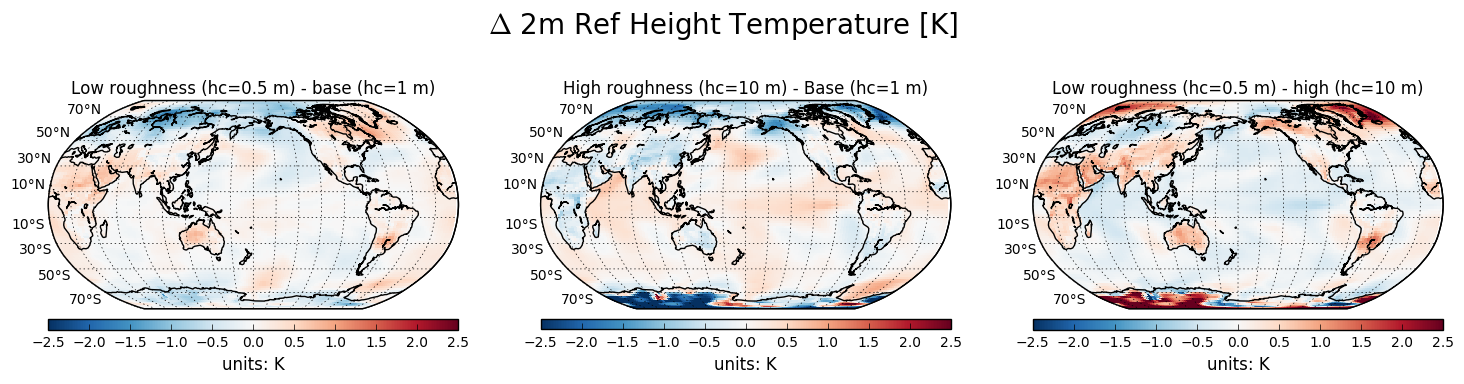

In [38]:
# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = '$\Delta$ 2m Ref Height Temperature [K]'
filename = myvar+'_3maps'

clim_abs = [220,320]
clim_diff = [-2.5,2.5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'Low roughness (hc=0.5 m) - base (hc=1 m)'
mapdata = mapdata_0
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'High roughness (hc=10 m) - Base (hc=1 m)'
mapdata = mapdata_1
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'Low roughness (hc=0.5 m) - high (hc=10 m)'
mapdata = mapdata_2
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)

Okay, so with this modified colour bar (roughness specific - response just got washed out when plotted with the others?), the response isn't non-existant over northern Eurasia, but it IS of opposite sign. So there is still something to dig into, there.

Response looks weak over the Amazon / USA.



## Turbuelent Heat Fluxes

### Sensible Heat

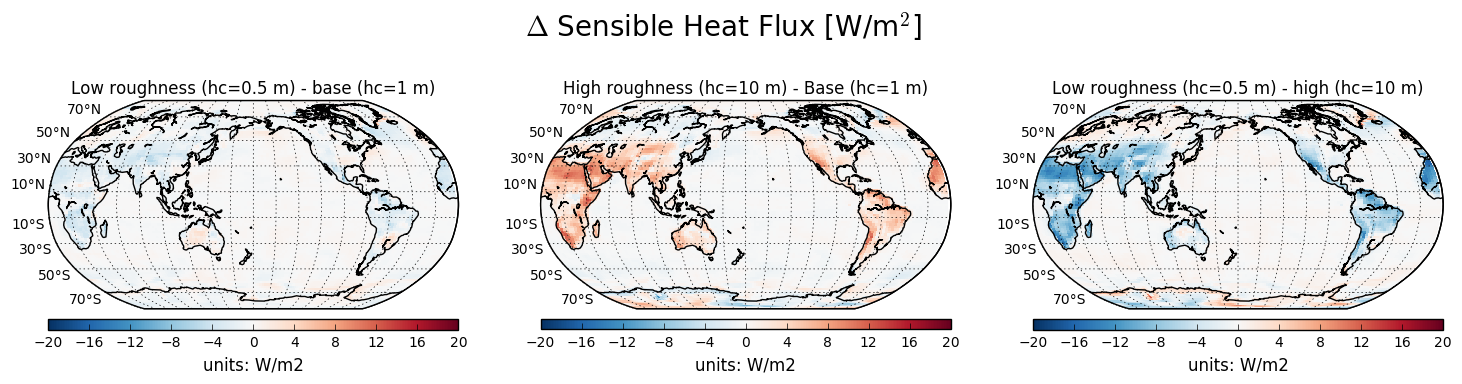

In [39]:
# Plots
myvar = 'SHFLX'

# hc0.5 - hc1
mapdata_nan = ds0[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#print(np.shape(mapdata))
mapdata_0 = np.mean(mapdata,0)
#print(np.shape(mapdata_0))

# hc10 - hc1
mapdata_nan = ds2[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_1 = np.mean(mapdata,0)

# hc0.5 - hc10
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_2 = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = '$\Delta$ Sensible Heat Flux [W/m$^2$]'
filename = myvar+'_3maps'

clim_abs = [220,320]
clim_diff = [-20,20]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'Low roughness (hc=0.5 m) - base (hc=1 m)'
mapdata = mapdata_0
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'High roughness (hc=10 m) - Base (hc=1 m)'
mapdata = mapdata_1
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'Low roughness (hc=0.5 m) - high (hc=10 m)'
mapdata = mapdata_2
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


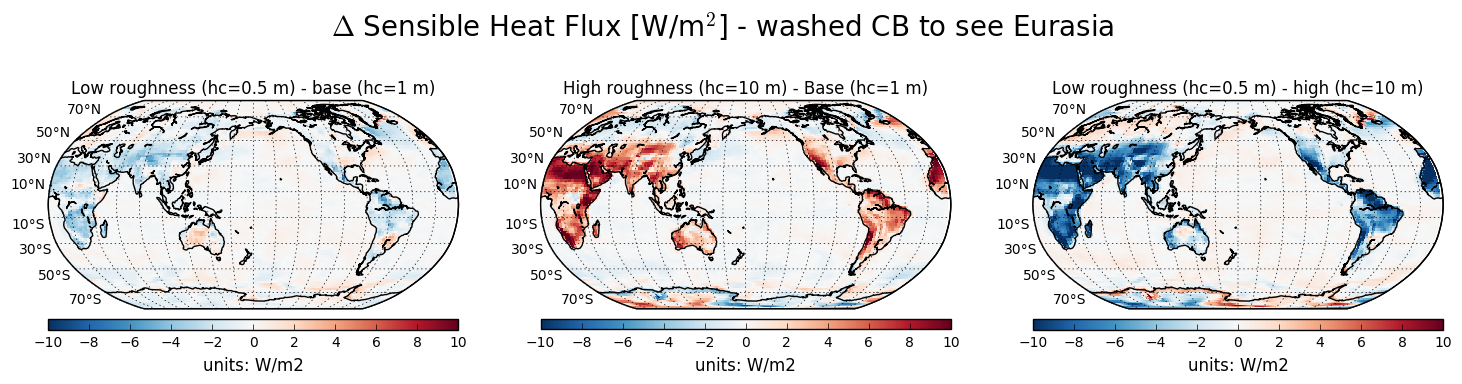

In [40]:
# Plots
myvar = 'SHFLX'

# hc0.5 - hc1
mapdata_nan = ds0[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#print(np.shape(mapdata))
mapdata_0 = np.mean(mapdata,0)
#print(np.shape(mapdata_0))

# hc10 - hc1
mapdata_nan = ds2[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_1 = np.mean(mapdata,0)

# hc0.5 - hc10
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_2 = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = '$\Delta$ Sensible Heat Flux [W/m$^2$] - washed CB to see Eurasia'
filename = myvar+'_3maps'

clim_abs = [220,320]
clim_diff = [-10,10]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'Low roughness (hc=0.5 m) - base (hc=1 m)'
mapdata = mapdata_0
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'High roughness (hc=10 m) - Base (hc=1 m)'
mapdata = mapdata_1
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'Low roughness (hc=0.5 m) - high (hc=10 m)'
mapdata = mapdata_2
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


### Latent Heat

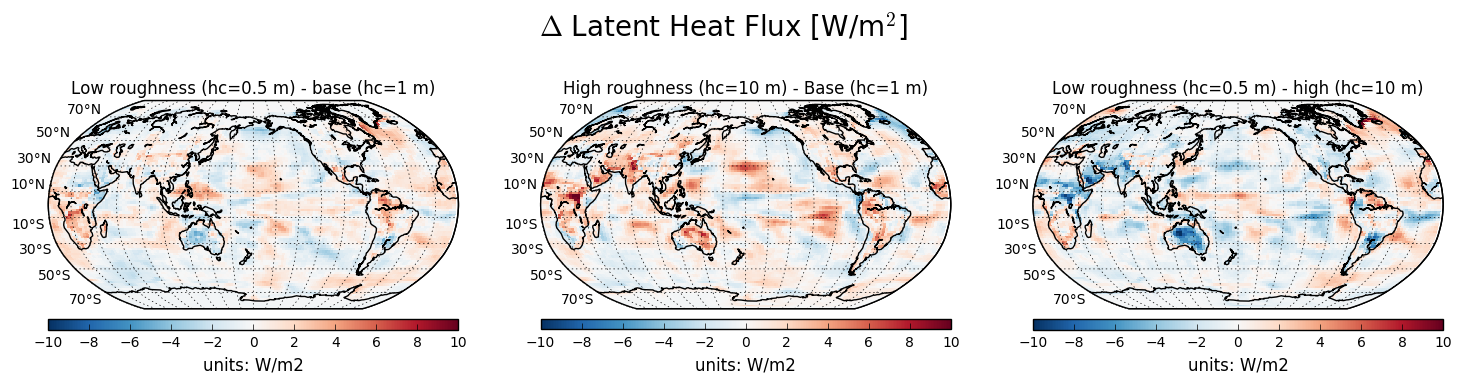

In [41]:
# Plots
myvar = 'LHFLX'

# hc0.5 - hc1
mapdata_nan = ds0[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#print(np.shape(mapdata))
mapdata_0 = np.mean(mapdata,0)
#print(np.shape(mapdata_0))

# hc10 - hc1
mapdata_nan = ds2[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_1 = np.mean(mapdata,0)

# hc0.5 - hc10
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_2 = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = '$\Delta$ Latent Heat Flux [W/m$^2$]'
filename = myvar+'_3maps'

clim_abs = [220,320]
clim_diff = [-10,10]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'Low roughness (hc=0.5 m) - base (hc=1 m)'
mapdata = mapdata_0
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'High roughness (hc=10 m) - Base (hc=1 m)'
mapdata = mapdata_1
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'Low roughness (hc=0.5 m) - high (hc=10 m)'
mapdata = mapdata_2
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


### Sum of Sensible + Latent Heat
(Though Sensible looks to be doing the most interesting amount, except over Australia - that could be worth checking how much water is left in the bucket, in case its just slow to evaporate? hmm... no, its been a while... though these simulations aren't spun up properly...')

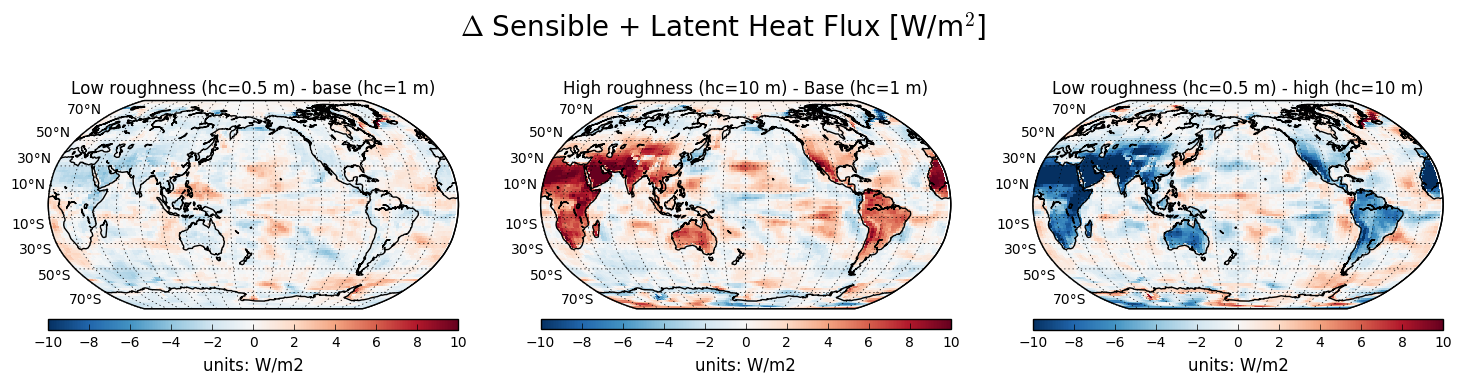

In [42]:
# Plots
myvar = 'SHFLX'
myvar2 = 'LHFLX'


# hc0.5 - hc1
mapdata_nan = (ds0[myvar].values.squeeze() + ds0[myvar2].values.squeeze()) - (ds1[myvar].values.squeeze()+ds1[myvar2].values.squeeze())
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#print(np.shape(mapdata))
mapdata_0 = np.mean(mapdata,0)
#print(np.shape(mapdata_0))

# hc10 - hc1
mapdata_nan = (ds2[myvar].values.squeeze() + ds2[myvar2].values.squeeze()) - (ds1[myvar].values.squeeze()+ds1[myvar2].values.squeeze())
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_1 = np.mean(mapdata,0)

# hc0.5 - hc10
mapdata_nan = (ds0[myvar].values.squeeze() + ds0[myvar2].values.squeeze()) - (ds2[myvar].values.squeeze()+ds2[myvar2].values.squeeze())
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_2 = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = '$\Delta$ Sensible + Latent Heat Flux [W/m$^2$]'
filename = myvar+'_'+myvar2+'_3maps'

clim_abs = [220,320]
clim_diff = [-10,10]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'Low roughness (hc=0.5 m) - base (hc=1 m)'
mapdata = mapdata_0
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'High roughness (hc=10 m) - Base (hc=1 m)'
mapdata = mapdata_1
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'Low roughness (hc=0.5 m) - high (hc=10 m)'
mapdata = mapdata_2
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)



Hmm... well, not much going on with net turblent flux (its not opposite in sign here, just weak). But it is weak elsewhere, also. So what does this suggest? The turblent fluxes aren't necessarily the obvious answer (contributing, but not flipping sign), yet the temperature goes up... What is left? Change in downwelling longwave or net absorbed shortwave. 

So, perhaps that is what I ought to explore next - radiative fluxes at the surface! Changes in those will imply changes in clouds / watervapour (in the instance of LW down), and I'll check clouds next, but first I want to make sure there IS a change in the surface radiation budget, because SOMETHING has to be driving this temperature change!!!

Note, also, that I'm STILL just looking in the annual mean - the seasonal analysis might tell a different tale. 

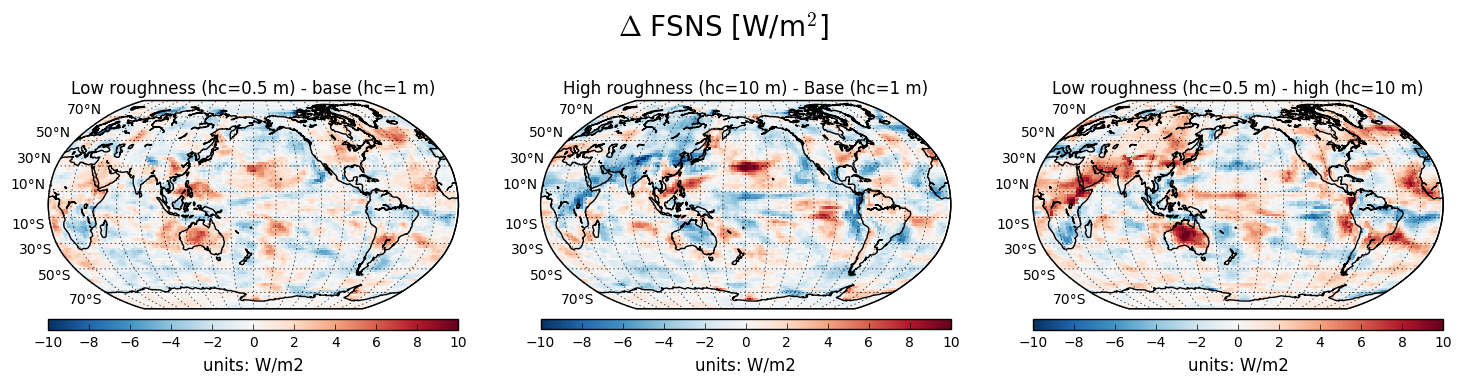

In [43]:
# Plots
myvar = 'FSNS'

# hc0.5 - hc1
mapdata_nan = ds0[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#print(np.shape(mapdata))
mapdata_0 = np.mean(mapdata,0)
#print(np.shape(mapdata_0))

# hc10 - hc1
mapdata_nan = ds2[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_1 = np.mean(mapdata,0)

# hc0.5 - hc10
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_2 = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = '$\Delta$ FSNS [W/m$^2$]'
filename = myvar+'_3maps'

clim_abs = [220,320]
clim_diff = [-10,10]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'Low roughness (hc=0.5 m) - base (hc=1 m)'
mapdata = mapdata_0
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'High roughness (hc=10 m) - Base (hc=1 m)'
mapdata = mapdata_1
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'Low roughness (hc=0.5 m) - high (hc=10 m)'
mapdata = mapdata_2
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


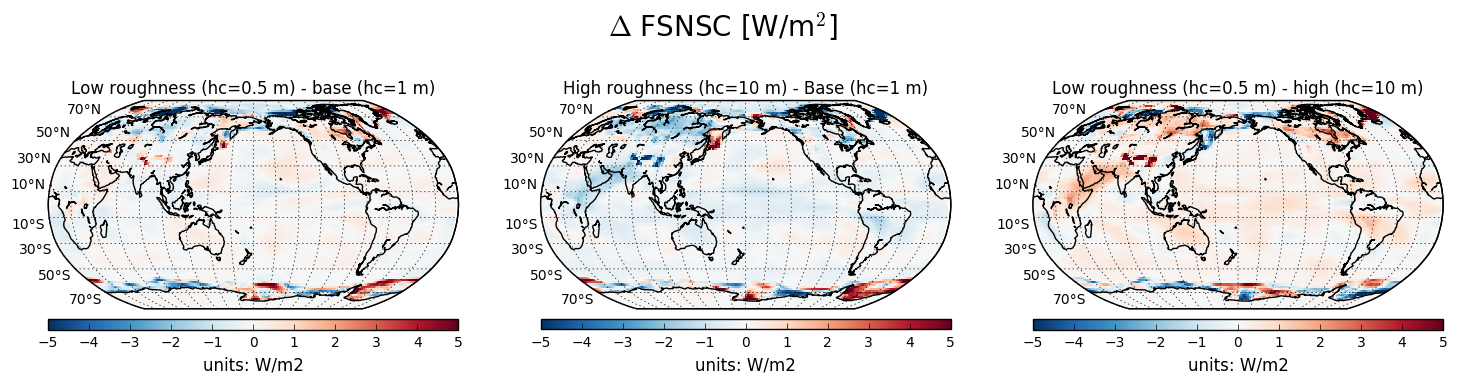

In [44]:
# Plots
myvar = 'FSNSC'

# hc0.5 - hc1
mapdata_nan = ds0[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#print(np.shape(mapdata))
mapdata_0 = np.mean(mapdata,0)
#print(np.shape(mapdata_0))

# hc10 - hc1
mapdata_nan = ds2[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_1 = np.mean(mapdata,0)

# hc0.5 - hc10
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_2 = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = '$\Delta$ FSNSC [W/m$^2$]'
filename = myvar+'_3maps'

clim_abs = [220,320]
clim_diff = [-5,5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'Low roughness (hc=0.5 m) - base (hc=1 m)'
mapdata = mapdata_0
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'High roughness (hc=10 m) - Base (hc=1 m)'
mapdata = mapdata_1
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'Low roughness (hc=0.5 m) - high (hc=10 m)'
mapdata = mapdata_2
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


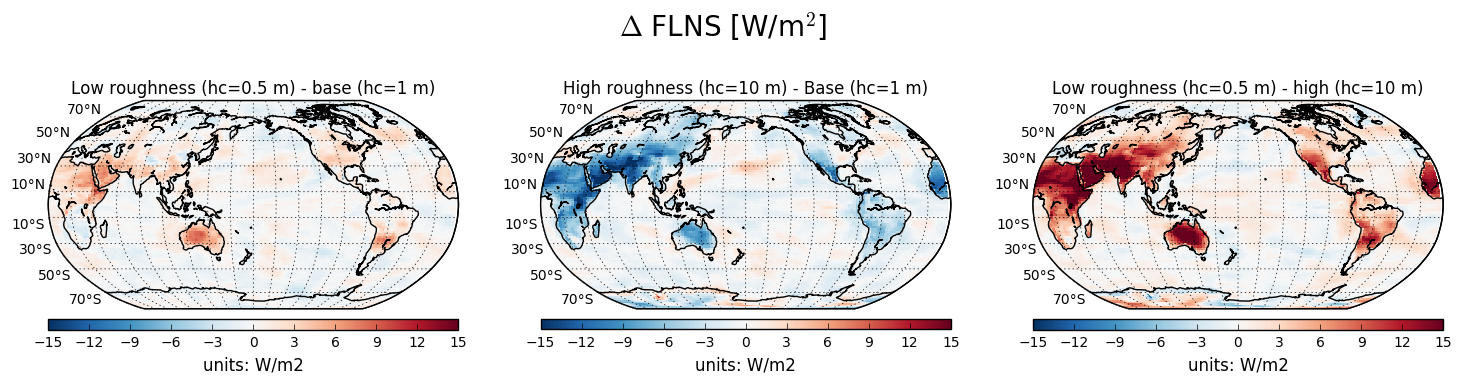

In [45]:
# Plots
myvar = 'FLNS'

# hc0.5 - hc1
mapdata_nan = ds0[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#print(np.shape(mapdata))
mapdata_0 = np.mean(mapdata,0)
#print(np.shape(mapdata_0))

# hc10 - hc1
mapdata_nan = ds2[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_1 = np.mean(mapdata,0)

# hc0.5 - hc10
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_2 = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = '$\Delta$ FLNS [W/m$^2$]'
filename = myvar+'_3maps'

clim_abs = [220,320]
clim_diff = [-15,15]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'Low roughness (hc=0.5 m) - base (hc=1 m)'
mapdata = mapdata_0
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'High roughness (hc=10 m) - Base (hc=1 m)'
mapdata = mapdata_1
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'Low roughness (hc=0.5 m) - high (hc=10 m)'
mapdata = mapdata_2
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


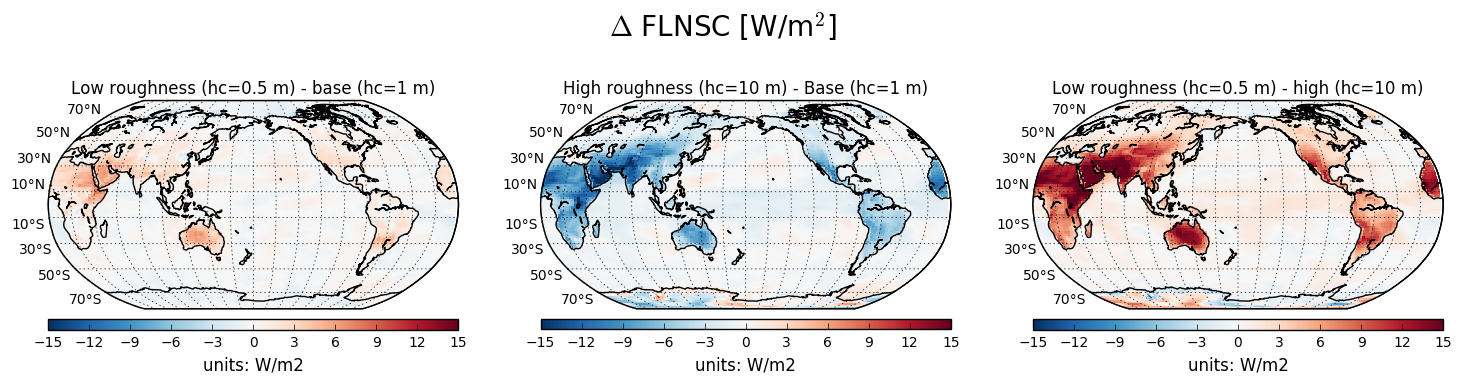

In [46]:
# Plots
myvar = 'FLNSC'

# hc0.5 - hc1
mapdata_nan = ds0[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#print(np.shape(mapdata))
mapdata_0 = np.mean(mapdata,0)
#print(np.shape(mapdata_0))

# hc10 - hc1
mapdata_nan = ds2[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_1 = np.mean(mapdata,0)

# hc0.5 - hc10
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_2 = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = '$\Delta$ FLNSC [W/m$^2$]'
filename = myvar+'_3maps'

clim_abs = [220,320]
clim_diff = [-15,15]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'Low roughness (hc=0.5 m) - base (hc=1 m)'
mapdata = mapdata_0
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'High roughness (hc=10 m) - Base (hc=1 m)'
mapdata = mapdata_1
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'Low roughness (hc=0.5 m) - high (hc=10 m)'
mapdata = mapdata_2
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


... What have I got to work with right now?

- the sign of the temperature response (both sfc and 2m air) is opposite that typically expected for the region of northern Eurasia
- There is little-to-no change in sensible heat fluxes over that region, and almost no change in latent heat flux. Certainly not clear changes the opposite direction those of everywhere else.
- Similarly, it doesn't look like there is an opposite sign in the change in FSNS, FSNSC, FLNS, or FLNSC over that region. 

So now, I really do probably have to go look seasonally, as perhaps there is a change in one of these fluxes during winter only, which is washed out to a net positive (or whatever consistent sign) over the course of the year, but has a large impact during a single season, enough to modify the annual mean temperature.

First, since I'm in the annual mean section, I'll do a quick pass at cloud cover.

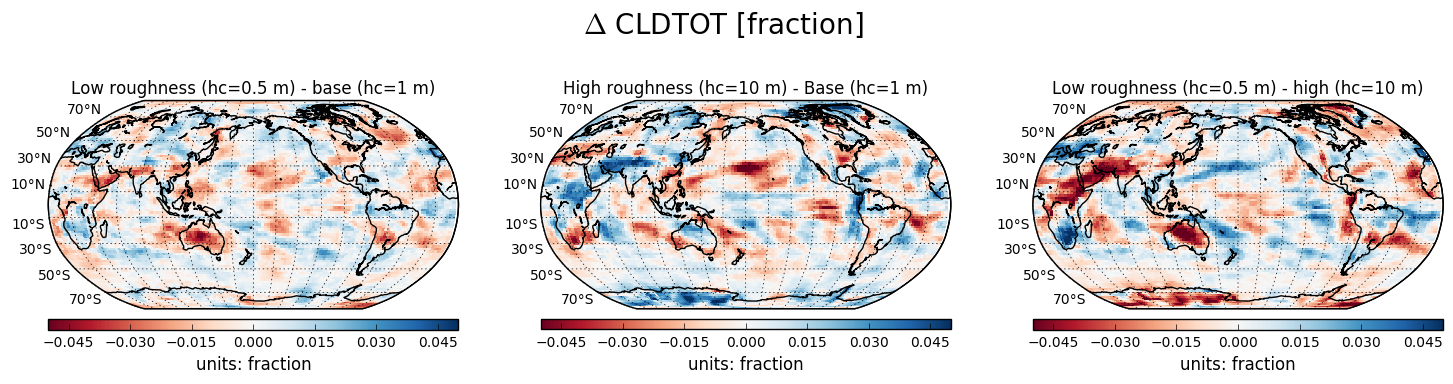

In [47]:
# Plots
myvar = 'CLDTOT'

# hc0.5 - hc1
mapdata_nan = ds0[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#print(np.shape(mapdata))
mapdata_0 = np.mean(mapdata,0)
#print(np.shape(mapdata_0))

# hc10 - hc1
mapdata_nan = ds2[myvar].values.squeeze() - ds1[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_1 = np.mean(mapdata,0)

# hc0.5 - hc10
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_2 = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = '$\Delta$ CLDTOT [fraction]'
filename = myvar+'_3maps'

clim_abs = [220,320]
clim_diff = [-.05,.05]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'Low roughness (hc=0.5 m) - base (hc=1 m)'
mapdata = mapdata_0
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'High roughness (hc=10 m) - Base (hc=1 m)'
mapdata = mapdata_1
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'Low roughness (hc=0.5 m) - high (hc=10 m)'
mapdata = mapdata_2
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


So many unanswered questions - as such, on to seasonal plots!!!

# SEASONAL

Now the plots will be of the form

    [ $\Delta$ DJF ]    |    [ $\Delta$ JJA ]    |    [ ($\Delta$ DFJ) - ($\Delta$ JJA) ]

(12, 96, 144)
(96, 144)


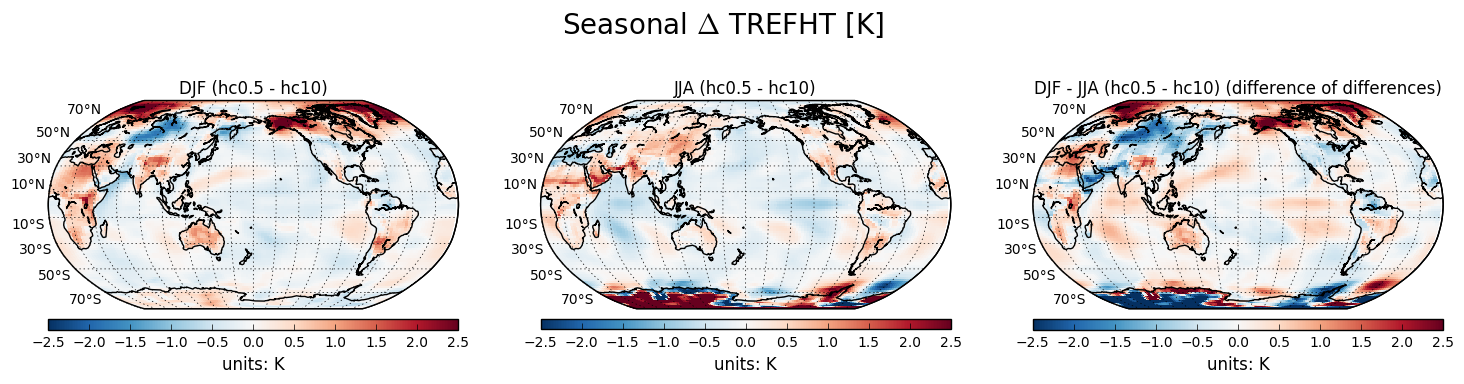

In [48]:
# Plots
myvar = 'TREFHT'

# hc0.5 - hc10

# DJF
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
print(np.shape(mapdata))
mapdata_djf = np.mean(mapdata[[11,0,1],:,:],0)
print(np.shape(mapdata_0))

# JJA
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_jja = np.mean(mapdata[[5,6,7],:,:],0)

# DJF - JJA (note: differnce of means!)
mapdata_seas = mapdata_djf - mapdata_jja
#mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
#mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#mapdata_seas = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = 'Seasonal $\Delta$ '+myvar+' ['+units+']'
filename = myvar+'_seas_maps'

clim_abs = [220,320]
clim_diff = [-2.5,2.5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'DJF (hc0.5 - hc10)'
mapdata = mapdata_djf
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'JJA (hc0.5 - hc10)'
mapdata = mapdata_jja
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'DJF - JJA (hc0.5 - hc10) (difference of differences)'
mapdata = mapdata_seas
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


(12, 96, 144)
(96, 144)


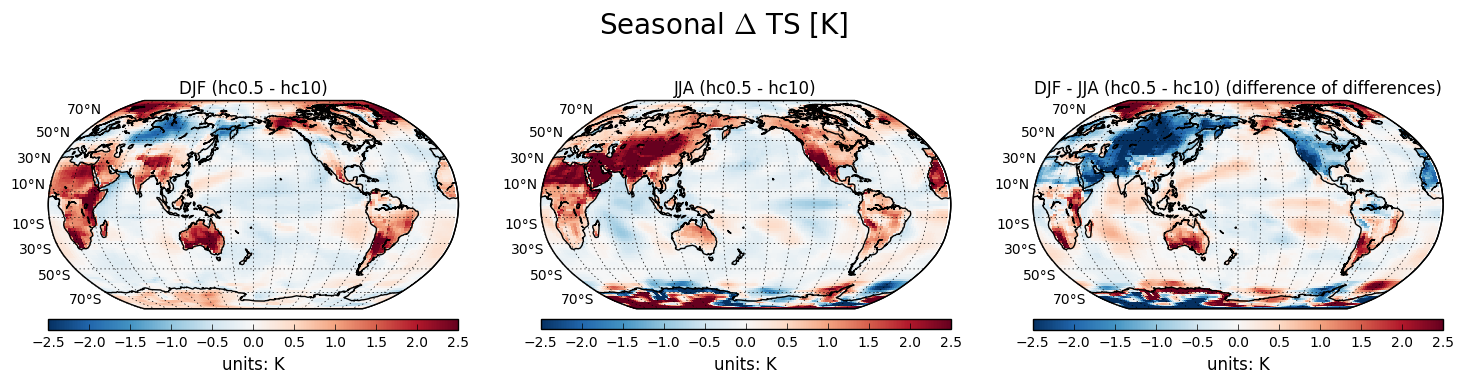

In [49]:
# Plots
myvar = 'TS'

# hc0.5 - hc10

# DJF
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
print(np.shape(mapdata))
mapdata_djf = np.mean(mapdata[[11,0,1],:,:],0)
print(np.shape(mapdata_0))

# JJA
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_jja = np.mean(mapdata[[5,6,7],:,:],0)

# DJF - JJA (note: differnce of means!)
mapdata_seas = mapdata_djf - mapdata_jja
#mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
#mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#mapdata_seas = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = 'Seasonal $\Delta$ '+myvar+' ['+units+']'
filename = myvar+'_seas_maps'

clim_abs = [220,320]
clim_diff = [-2.5,2.5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'DJF (hc0.5 - hc10)'
mapdata = mapdata_djf
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'JJA (hc0.5 - hc10)'
mapdata = mapdata_jja
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'DJF - JJA (hc0.5 - hc10) (difference of differences)'
mapdata = mapdata_seas
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


(12, 96, 144)
(96, 144)


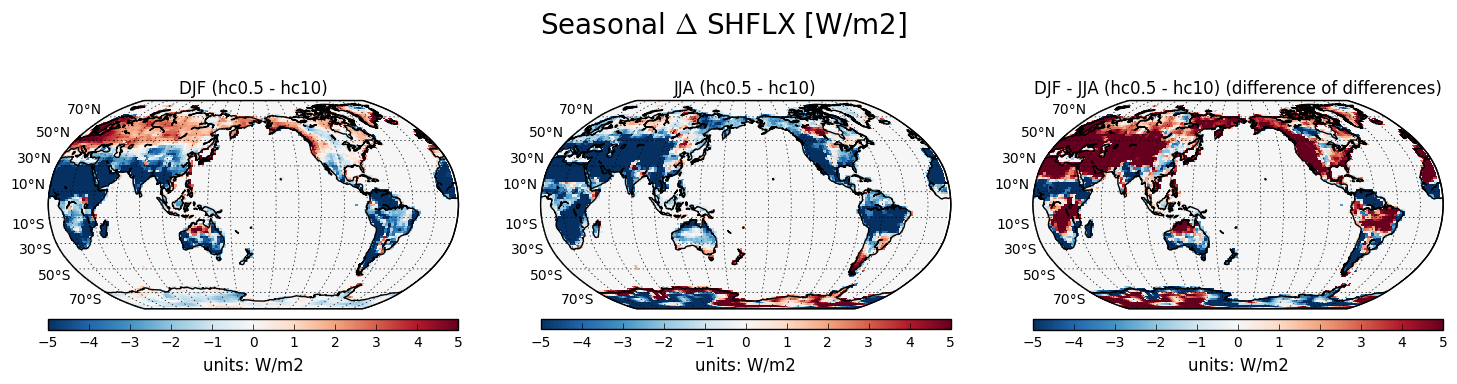

In [88]:
# Plots
myvar = 'SHFLX'

# hc0.5 - hc10

# DJF
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
print(np.shape(mapdata))
mapdata_djf = np.mean(mapdata[[11,0,1],:,:],0)
print(np.shape(mapdata_0))

# JJA
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_jja = np.mean(mapdata[[5,6,7],:,:],0)

# DJF - JJA (note: differnce of means!)
mapdata_seas = mapdata_djf - mapdata_jja
#mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
#mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#mapdata_seas = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = 'Seasonal $\Delta$ '+myvar+' ['+units+']'
filename = myvar+'_seas_maps'

clim_abs = [220,320]
clim_diff = [-5,5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'DJF (hc0.5 - hc10)'
mapdata = mapdata_djf*landmask
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'JJA (hc0.5 - hc10)'
mapdata = mapdata_jja*landmask
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'DJF - JJA (hc0.5 - hc10) (difference of differences)'
mapdata = mapdata_seas*landmask
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


(12, 96, 144)
(96, 144)


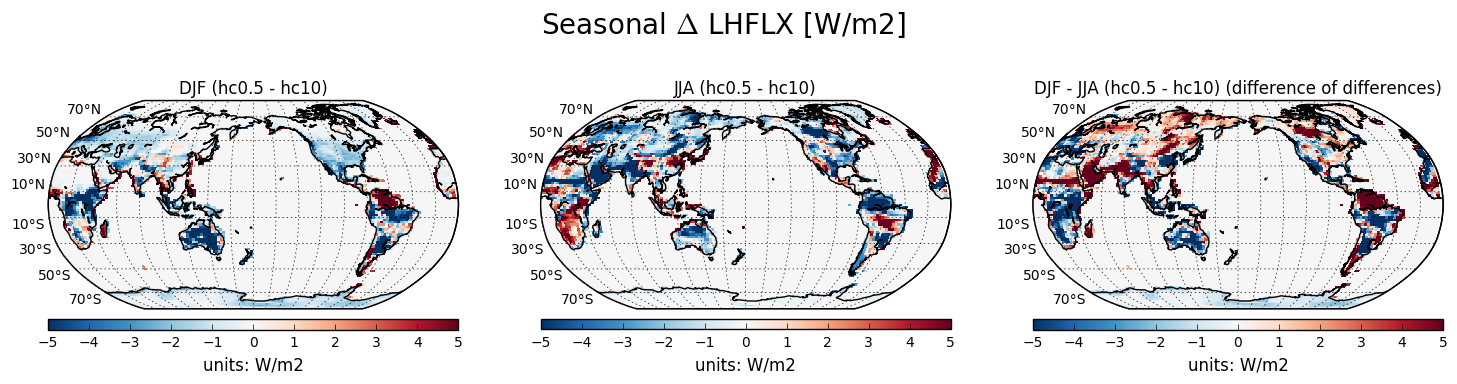

In [89]:
# Plots
myvar = 'LHFLX'

# hc0.5 - hc10

# DJF
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
print(np.shape(mapdata))
mapdata_djf = np.mean(mapdata[[11,0,1],:,:],0)*landmask
print(np.shape(mapdata_0))

# JJA
mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_jja = np.mean(mapdata[[5,6,7],:,:],0)*landmask

# DJF - JJA (note: differnce of means!)
mapdata_seas = mapdata_djf - mapdata_jja
#mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
#mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#mapdata_seas = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = 'Seasonal $\Delta$ '+myvar+' ['+units+']'
filename = myvar+'_seas_maps'

clim_abs = [220,320]
clim_diff = [-5,5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'DJF (hc0.5 - hc10)'
mapdata = mapdata_djf
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'JJA (hc0.5 - hc10)'
mapdata = mapdata_jja
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'DJF - JJA (hc0.5 - hc10) (difference of differences)'
mapdata = mapdata_seas
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


## Is there a lack of snow causing the opposite sign over northern Eurasia?

(12, 96, 144)
(96, 144)


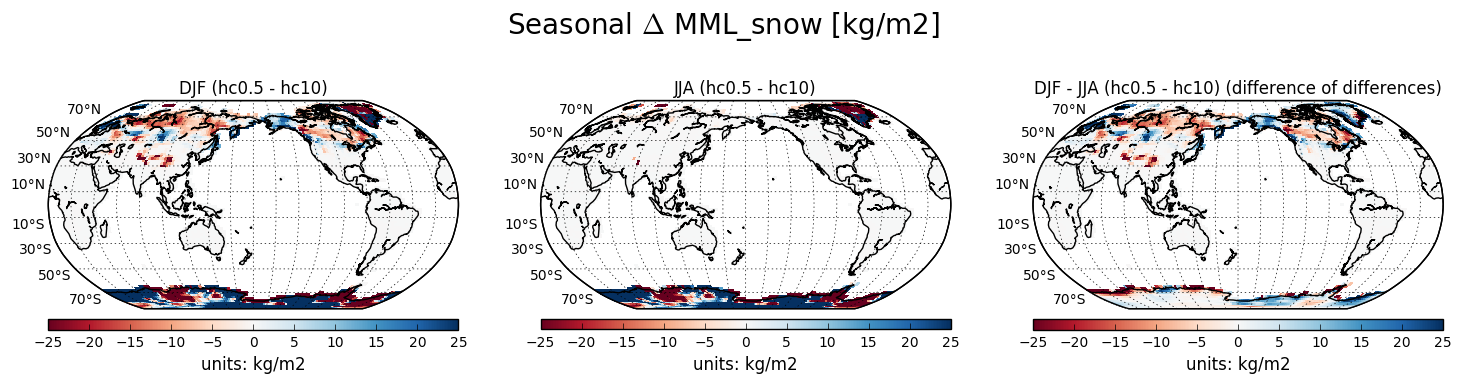

In [85]:
# Plots
myvar = 'MML_snow'

# hc0.5 - hc10

# DJF
mapdata_nan = dsl0[myvar].values.squeeze() - dsl2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
print(np.shape(mapdata))
mapdata_djf = np.mean(mapdata[[11,0,1],:,:],0)
print(np.shape(mapdata_0))

# JJA
mapdata_nan = dsl0[myvar].values.squeeze() - dsl2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_jja = np.mean(mapdata[[5,6,7],:,:],0)

# DJF - JJA (note: differnce of means!)
mapdata_seas = mapdata_djf - mapdata_jja
#mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
#mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#mapdata_seas = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = dsl0[myvar].units

ttl_main = 'Seasonal $\Delta$ '+myvar+' ['+units+']'
filename = myvar+'_seas_maps'

clim_abs = [220,320]
clim_diff = [-25,25]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'DJF (hc0.5 - hc10)'
mapdata = mapdata_djf
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'JJA (hc0.5 - hc10)'
mapdata = mapdata_jja
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'DJF - JJA (hc0.5 - hc10) (difference of differences)'
mapdata = mapdata_seas
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


(12, 96, 144)
(96, 144)


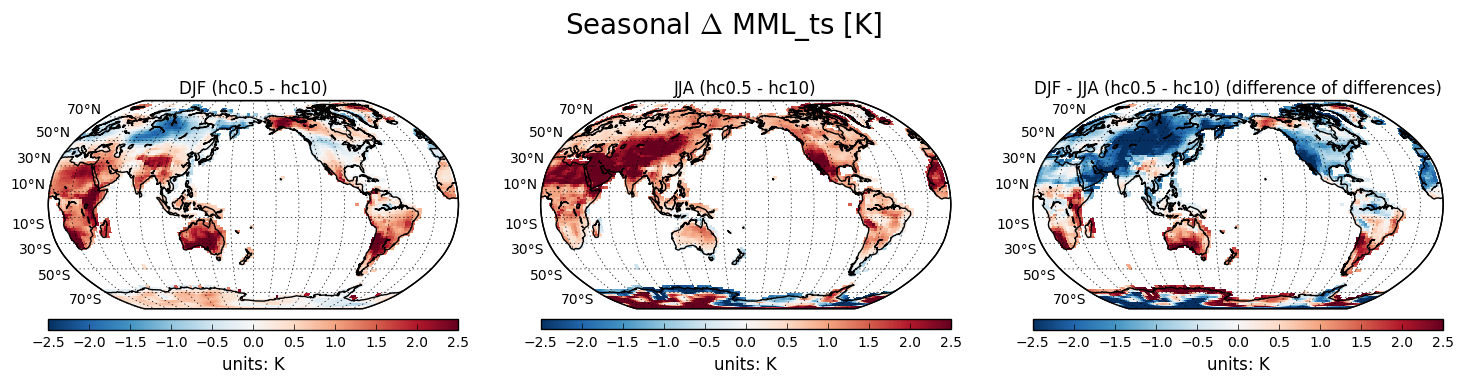

In [94]:
# Plots
myvar = 'MML_ts'

# hc0.5 - hc10

# DJF
mapdata_nan = dsl0[myvar].values.squeeze() - dsl2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
print(np.shape(mapdata))
mapdata_djf = np.mean(mapdata[[11,0,1],:,:],0)
print(np.shape(mapdata_0))

# JJA
mapdata_nan = dsl0[myvar].values.squeeze() - dsl2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_jja = np.mean(mapdata[[5,6,7],:,:],0)

# DJF - JJA (note: differnce of means!)
mapdata_seas = mapdata_djf - mapdata_jja
#mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
#mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#mapdata_seas = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = dsl0[myvar].units

ttl_main = 'Seasonal $\Delta$ '+myvar+' ['+units+']'
filename = myvar+'_seas_maps'

clim_abs = [220,320]
clim_diff = [-2.5,2.5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'DJF (hc0.5 - hc10)'
mapdata = mapdata_djf
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'JJA (hc0.5 - hc10)'
mapdata = mapdata_jja
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'DJF - JJA (hc0.5 - hc10) (difference of differences)'
mapdata = mapdata_seas
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


# Focus on winter, see if anything notable is happening with mean values (e.g. above/below freezing line?)

In [ ]:
### T in deg C

(12, 96, 144)
(96, 144)
(12, 96, 144)
(96, 144)
(12, 96, 144)
(96, 144)


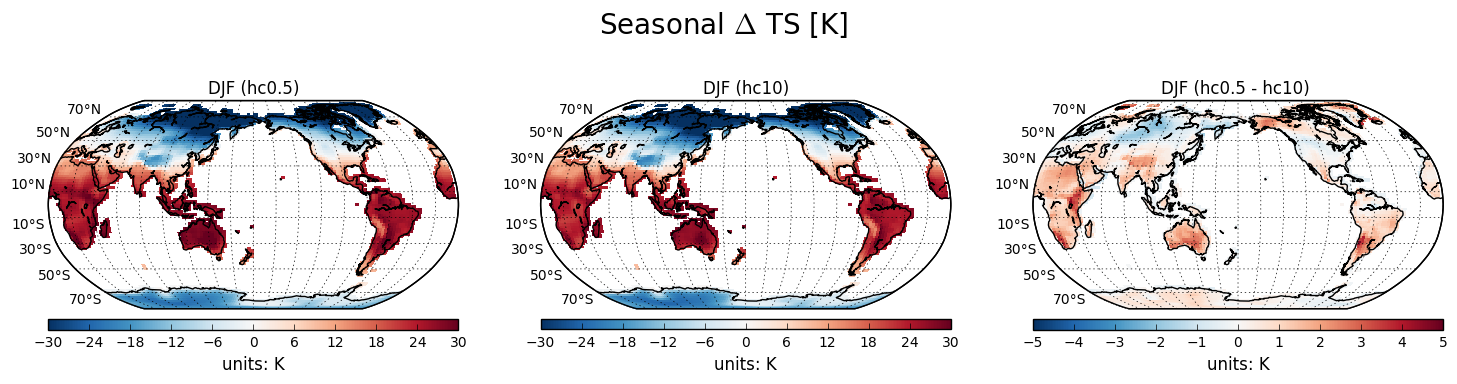

In [104]:
# Plots
myvar = 'TS'

# hc0.5 - hc10

# DJF hc0.5
mapdata_nan = ds0[myvar].values.squeeze() *landmask_nan
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
print(np.shape(mapdata))
mapdata_djf_0 = np.mean(mapdata[[11,0,1],:,:],0)
print(np.shape(mapdata_0))


# DJF hc10
mapdata_nan = ds2[myvar].values.squeeze()*landmask_nan
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
print(np.shape(mapdata))
mapdata_djf_2 = np.mean(mapdata[[11,0,1],:,:],0)
print(np.shape(mapdata_0))


# DJF hc0.5 - hc10
mapdata_nan = (ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze())*landmask_nan
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
print(np.shape(mapdata))
mapdata_djf_diff = np.mean(mapdata[[11,0,1],:,:],0)
print(np.shape(mapdata_0))



# -------------------------------
# Relevant details

units = ds0[myvar].units

ttl_main = 'Seasonal $\Delta$ '+myvar+' ['+units+']'
filename = myvar+'_seas_maps_diff'

clim_abs = [220,300]
clim_abs = [-30,30]   # temporary! 
clim_diff = [-5,5]
cmap_abs = plt.cm.viridis
cmap_abs = plt.cm.RdBu_r   # temporary!
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'DJF (hc0.5)'
mapdata = mapdata_djf_0 - 273.15
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'DJF (hc10)'
mapdata = mapdata_djf_2 - 273.15
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'DJF (hc0.5 - hc10) '
mapdata = mapdata_djf_diff
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


Dig up a glacier mask; I don't save it (silly), so I'll have to back it out of something

(96, 144)


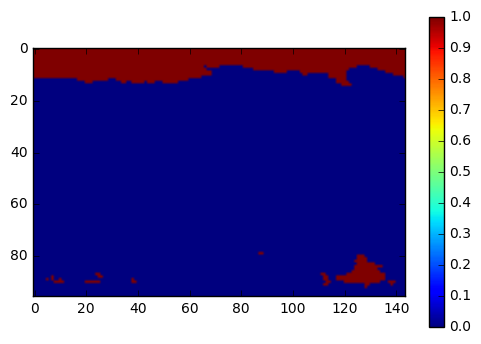

In [83]:
temp = np.mean(dsl0.mean('time')['MML_cv'].values[:],0)
print(np.shape(temp))
#plt.imshow(temp)
#plt.colorbar()
temp2 = temp.copy()
is_glc = np.where(temp2>1950000,0,1)*landmask
no_glc = np.where(temp2>1950000,1,0)
plt.imshow(is_glc)
plt.colorbar()

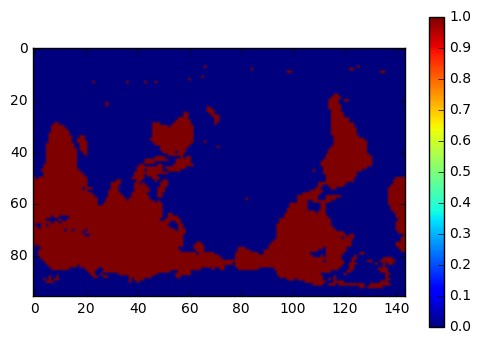

In [84]:
plt.imshow(no_glc)
plt.colorbar()

In [60]:
# Plots
myvar = 'MML_snow'

# mask out glaciers
#glc_mask = dsl0['glc_mask'].values[:]
# darn, don't save hte glacier mask out. Silly. I should do that. 
# hc0.5 - hc10

# DJF hc 0.5
mapdata_nan = dsl0[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_ds0 = np.mean(mapdata[[11,0,1],:,:],0)

# DFJ hc 10
mapdata_nan = dsl2[myvar].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
mapdata_ds2 = np.mean(mapdata[[5,6,7],:,:],0)

# DJF  hc0.5 - hc10
mapdata_diff = mapdata_ds0 - mapdata_ds2
#mapdata_nan = ds0[myvar].values.squeeze() - ds2[myvar].values.squeeze()
#mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)
#mapdata_seas = np.mean(mapdata,0)


# -------------------------------
# Relevant details

units = dsl0[myvar].units

ttl_main = 'Seasonal DFJ background '+myvar+' ['+units+']'
filename = myvar+'background_seas_maps'

clim_abs = [0,200]
clim_diff = [-50,50]
cmap_abs = plt.cm.viridis_r
cmap_diff = plt.cm.RdBu

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'DJF hc0.5'
mapdata = mapdata_ds0
mp0, cbar0, cs0 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'DJF hc10'
mapdata = mapdata_ds2
mp1, cbar1, cs1 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'DJF hc0.5 - hc10'
mapdata = mapdata_diff
mp2, cbar2, cs2 = mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
fig_name = figpath+'/roughness/'+filename+'.eps'
fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
            edgecolor='w',orientation='portrait',bbox_inches='tight', 
            pad_inches=0.1,frameon=None)


NameError: name 'ds10' is not defined

(96, 144)


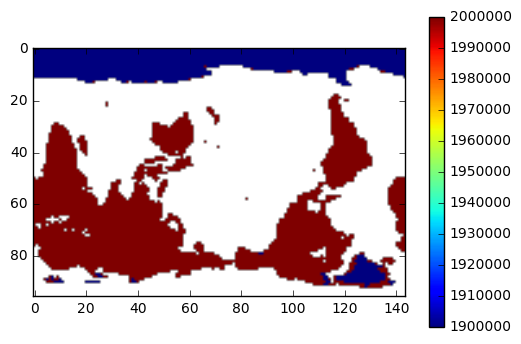

In [62]:
dsl0.var

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:            (hist_interval: 2, lat: 96, levdcmp: 1, levgrnd: 25, levlak: 10, lon: 144, mml_dust: 4, mml_lev: 10, time: 12)
Coordinates:
  * levgrnd            (levgrnd) float32 0.01 0.04 0.09 0.16 0.26 0.4 0.58 ...
  * levlak             (levlak) float32 0.05 0.6 2.1 4.6 8.1 12.6 18.6 25.6 ...
  * levdcmp            (levdcmp) float32 1.0
  * mml_lev            (mml_lev) float32 -0.00710064 -0.027925 -0.0622586 ...
  * mml_dust           (mml_dust) float32 0.0 0.0 0.0 0.0
  * time               (time) object   10-02-01 00:00:00   10-03-01 00:00:00 ...
  * lon                (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 ...
  * lat                (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 ...
Dimensions without coordinates: hist_interval
Data variables:
    mcdate             (time) int32 100201 100301 100401 100501 100601 ...
    mcsec              (time) int32 0 0 0 0 0 0 